# Stages
- Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
- Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
- Data Cleaning – imputing missing values in the data and checking for outliers
- Feature Engineering – modifying existing variables and creating new ones for analysis.
- Model Building – making predictive models on the data  (Not required as per assessment)

# 1.) Hypothesis Generation

Best Customer Hypotheses:

- RFM: Recency, Frequency and Monetary analysis is one of the proven benchmark for customer evaluation. Recency is days since last perchase. Frequency is total no of transaction. Monetary is total money spent.
- Pareto Principle: 80% of the effects come from 20% causes. Hence, there must be around small chunk of customers generating around 80% of the total revenue. People who spent big are more likely to repeat them.

Replenishmemt Behavior Hypotheses:

- Location: People should be purchasing maximum from stores as supermarkets has a very big and accessible chain of stores.
- Traffic: Shopping on weekdays will be less as compared to weekends/holidays. Explanation - People will go to office on weekdays. Also, Friday and Saturday will have maximum purchases as compared to Sundays, sometime people tend to get stuffs and groceries while coming back to home from work.
- Utility: Daily use products and groceries should have a higher tendency to sell as compared to the specific use products.
- Special Sale: Sales will be maximum in Nov and Dec due to multiple holidays and super sales like Black Friday / Cyber Monday / Christmas / Thanksgiving / New Year.
- Trend: Overall buying trend should be similar throughout the data as buying grocery and household stuffs is not a seasonal thing.
- Monetary Analysis: Maximum percentage of buyers will shop for very less amount as the Grocery and household won't cost a fortune to buy.
- Cohort Analysis- Breaking different customers into sub-related groups to see patterns such as retention or buying.
   

# 2.) Data Exploration

In [1]:
#import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#read file
data = pd.read_excel('customer.csv')

In [3]:
#checking data 
data.describe()

,customer_id,sales
count,36797.000000,36797.000000
mean,460.603935,64.082802
std,266.281239,529.518545
min,1.000000,-298.000000
25%,233.000000,16.020000
50%,457.000000,35.690000
75%,689.000000,73.300000
max,1000.000000,71262.000000


observations
- There are 36797 customer's purchase in total.
- The avg money spend by a customer per visit is 64.08.
- Sales min has a -ve value -298 which shouldn't be possible, we have to remove those values. Though we can fill those values with the avg or min or max purchase, But filling those with these values will make data more bias in my judgement. Let say 2 purchase and 1 is -ve and other is a very high value.
- There are 1000 unique customers.

In [4]:
data.dtypes

customer_id                 int64
order_date         datetime64[ns]
shopping_medium            object
department                 object
sales                     float64
dtype: object

In [5]:
#checking for the null values
data.apply(lambda x: sum(x.isnull()), axis=0)

customer_id            0
order_date             0
shopping_medium        0
department         33544
sales                  0
dtype: int64

observations
- There is no null value as such.
- There are missing values in department as department is specified only for the OG or DOTCOM.

In [6]:
data.head()

,customer_id,order_date,shopping_medium,department,sales
0,407,2017-05-01,DOTCOM,PHOTO,3.80
1,457,2017-05-01,STORE,NaN,17.85
2,765,2017-05-01,STORE,NaN,27.35
3,407,2017-05-01,STORE,NaN,205.40
4,264,2017-05-01,STORE,NaN,48.93


In [7]:
data.apply(lambda x: len(x.unique()))

customer_id         1000
order_date           729
shopping_medium        3
department            25
sales              13632
dtype: int64

In [8]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['customer_id','Order_date','sales']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(data[col].value_counts())


Frequency of Categories for varible shopping_medium
STORE     33427
DOTCOM     2244
OG         1126
Name: shopping_medium, dtype: int64

Frequency of Categories for varible department
GROCERY              476
HOUSEHOLD            406
ROOMS                371
HEALTH AND BEAUTY    302
ELECTRONICS          223
BABY                 179
APPAREL              169
TOYS                 165
PHOTO                147
BOOKS                137
HOME IMPROVEMENT      82
SPORTING GOODS        82
OFFICE SUPPLIES       80
AUTOMOTIVE PARTS      71
PETS                  71
HOME DECOR            54
ARTS AND CRAFTS       50
OUTDOOR               48
TOOLS EQUIPMENT       39
SERVICES              35
PERSONAL CARE         22
FOOTWEAR              18
ACCESSORIES           16
JEWELRY               10
Name: department, dtype: int64


Observations
- My location hypothesis is justified as People count in store is maximum as compared to OG and DOTCOM
- My utility hypothesis also seems to stand as Grocery and Household stands on top with maximum sell.

# 3.) Data Cleaning

In [9]:
#taking all the rows having sales figure greater than 0.
data = data[(data['sales']>0)]

In [10]:
data.describe()

,customer_id,sales
count,36557.000000,36557.000000
mean,460.666028,64.678749
std,266.271936,531.191707
min,1.000000,0.090000
25%,233.000000,16.430000
50%,457.000000,35.960000
75%,689.000000,73.700000
max,1000.000000,71262.000000


observation
- No negative value for sales.

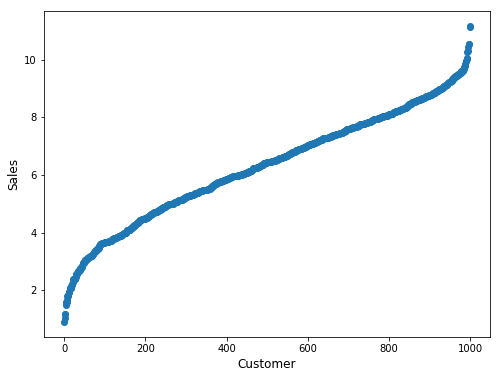

In [11]:
# Taking log to normalize 
data['sales'] = data['sales'].astype('float')
gdf = data.groupby("customer_id")['sales'].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf['sales'].values)))
plt.xlabel('Customer', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.show()

Wow, This confirms the pareto principle not exactly but subtly.
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.
In this case, the ratio is around 60 / 40 as it seems.

# 4.) Feature Engineering

In [12]:
data.order_date.min()

Timestamp('2017-05-01 00:00:00')

In [13]:
data.order_date.max()

Timestamp('2019-04-30 00:00:00')

Our data is from 2017-05-01 to 2019-04-30 i.e 2 years

In [14]:
import datetime as dt
NOW = dt.datetime(2019,5,1)

In [15]:
#Creating RFM table and calculating RFM metrics for each customer
#renaming the coumns for better representation.
rfmTable = data.groupby('customer_id').agg({'order_date': lambda x: (NOW - x.max()).days, 'customer_id': lambda x: len(x), 'sales': lambda x: x.sum()})
rfmTable['order_date'] = rfmTable['order_date'].astype(int)
rfmTable.rename(columns={'order_date': 'recency', 'customer_id': 'frequency', 'sales': 'monetary_value'}, inplace=True)

In [16]:
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
1,10,104,2217.83
2,520,1,20.00
3,30,82,6464.74
4,166,7,398.23
5,33,19,690.12


observations
- Customer with id 1 came 10 days before. He came 104 times in total and bought stuffs worth 2217.83 in total.

In [17]:
#Creating 4 segments which will help in more detailed analysis.
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [18]:
segmented_rfm = rfmTable

In [19]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [20]:
#Add segment numbers to the newly created segmented RFM table
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
1,10,104,2217.83,1,1,2
2,520,1,20.00,4,4,4
3,30,82,6464.74,2,1,1
4,166,7,398.23,3,3,3
5,33,19,690.12,2,2,2


In [21]:
#Adding a new column to combine RFM score: 111 is the highest score
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_id,,,,,,,
1,10,104,2217.83,1,1,2,112
2,520,1,20.00,4,4,4,444
3,30,82,6464.74,2,1,1,211
4,166,7,398.23,3,3,3,333
5,33,19,690.12,2,2,2,222


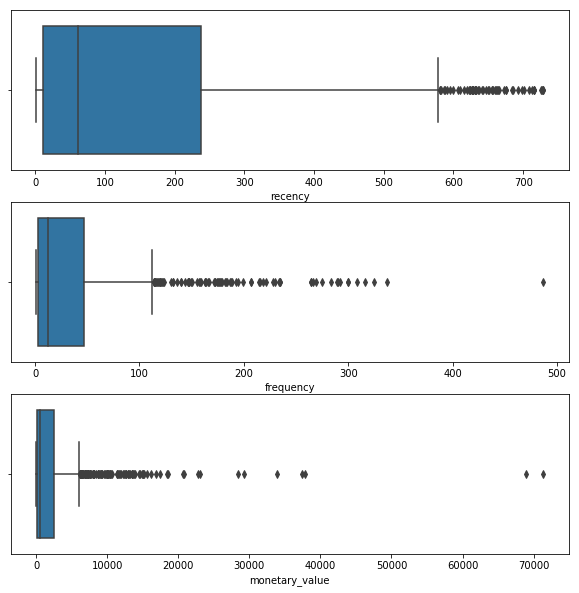

In [22]:
# Plot recency, freqiency and moneatry distribution
fig,ax=plt.subplots(3,1)
fig.set_size_inches(w=10,h=10)
sns.boxplot(x='recency',data=segmented_rfm,ax=fig.axes[0])
sns.boxplot(x='frequency',data=segmented_rfm,ax=fig.axes[1])
sns.boxplot(x='monetary_value',data=segmented_rfm,ax=fig.axes[2])

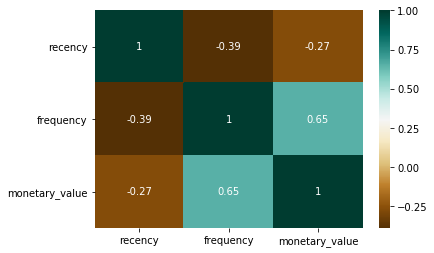

In [23]:
#creating heatmap for correlation
c= segmented_rfm[['recency','frequency','monetary_value']].corr()
sns.heatmap(data=c,cmap="BrBG",annot=True)
plt.show()

observations-
- We can see that frequency and monetary_value have a high positive correlation that means a more frequent customer is likely to raise the revenue for company.
- Again we can see -ve correlation between frequency and recency. A more frequent customer has less recency.

### Who are the top 10 of our best customers!

In [24]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
customer_id,,,,,,,
407,1,487,37900.90,1,1,1,111
475,7,230,37385.04,1,1,1,111
638,3,235,29226.28,1,1,1,111
502,1,337,28369.69,1,1,1,111
188,3,292,23091.15,1,1,1,111
937,4,150,22787.06,1,1,1,111
882,3,264,20877.51,1,1,1,111
716,3,103,20666.88,1,1,1,111
231,4,174,18356.72,1,1,1,111


### Q1 Answered-  Above is the list of top 10 customers with highest monetary value, highest frequency and least recency.

In [25]:
#making a copy of the df
data_time = data.copy()

In [26]:
#making a new dataframe with column order_date
data_count = data_time[['order_date']]

In [27]:
#Taking the count of sales on each day.
df_grp = data_count.groupby('order_date')
ts = df_grp.size().reset_index(name='count')

In [28]:
#column count added
ts.head()

,order_date,count
0,2017-05-01,52
1,2017-05-02,40
2,2017-05-03,59
3,2017-05-04,56
4,2017-05-05,66


In [29]:
ts['order_date'] = pd.to_datetime(ts.order_date,format='%d-%m-%Y')

In [30]:
#I made some hypothesis for the effect of day, month and year on the customer count. So, let’s extract the year, month and day from the Datetime to validate my hypothesis.
ts['year']=ts.order_date.dt.year 
ts['month']=ts.order_date.dt.month 
ts['day']=ts.order_date.dt.day

In [31]:
#First extract the day of week from Datetime and then based on the values we will assign whether the day is a weekend or not.
#Values of 5 and 6 represents that the days are weekend.
ts['day of week']=ts['order_date'].dt.dayofweek 
temp = ts['order_date']

In [32]:
#Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.
def week_(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = ts['order_date'].apply(week_) 
ts['weekend']=temp2

In [33]:
#columns added
ts.head(10)

,order_date,count,year,month,day,day of week,weekend
0,2017-05-01,52,2017,5,1,0,0
1,2017-05-02,40,2017,5,2,1,0
2,2017-05-03,59,2017,5,3,2,0
3,2017-05-04,56,2017,5,4,3,0
4,2017-05-05,66,2017,5,5,4,0
5,2017-05-06,63,2017,5,6,5,1
6,2017-05-07,61,2017,5,7,6,1
7,2017-05-08,57,2017,5,8,0,0
8,2017-05-09,50,2017,5,9,1,0
9,2017-05-10,39,2017,5,10,2,0


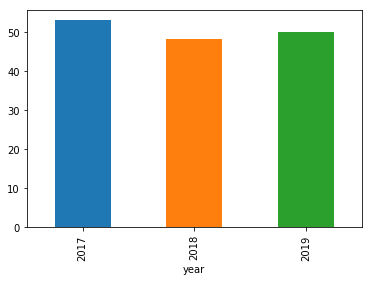

In [34]:
#Hypothesis test
ts.groupby('year')['count'].mean().plot.bar()

Observation
- The buying trend is similar though 2018 and 2017.
- The customer count though have increased a lot in 2019 as just for 4 months of data the count is almost equal to previous years.

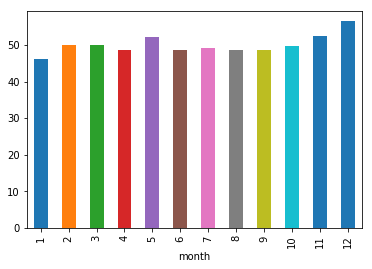

In [35]:
#Hypothesis test
ts.groupby('month')['count'].mean().plot.bar()

Observation
-  My hypothesis about the special sale seems to be validated as we can see more sales in Nov and Dec which are generally months with huge offers, holidays and discounts.

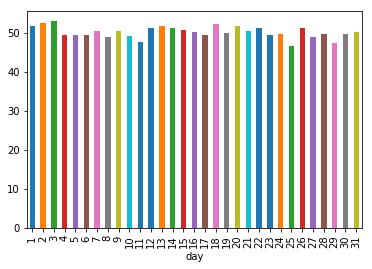

In [36]:
#Hypothesis
ts.groupby('day')['count'].mean().plot.bar()

Observation
- The buying trend is again similar as grocery and household items are needed daily though we can see some wavy representation which are due to weekends and weekdays which again validates my hypothesis.
- I can see more thing here that the buying increases at the start of each month which might because of the salary paid during last week of each prev month. We can easily see increased traffic at the start of the month. Also, there is some subtle increase during the mid time of the month around 17-20.

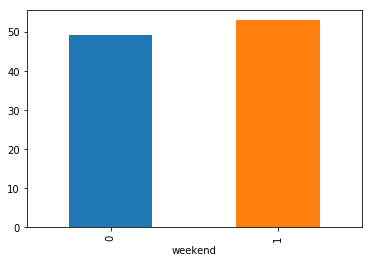

In [37]:
#Hypothesis
ts.groupby('weekend')['count'].mean().plot.bar()

Observation
- The plot validates that people buy more on weeekends rather than weekdays.

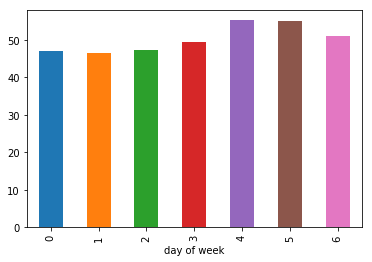

In [38]:
#Hypothesis
ts.groupby('day of week')['count'].mean().plot.bar()

Observation
- My hypothesis about the Fridays and Saturdays also seem to be validated. Same thing about weekends and weekdays.

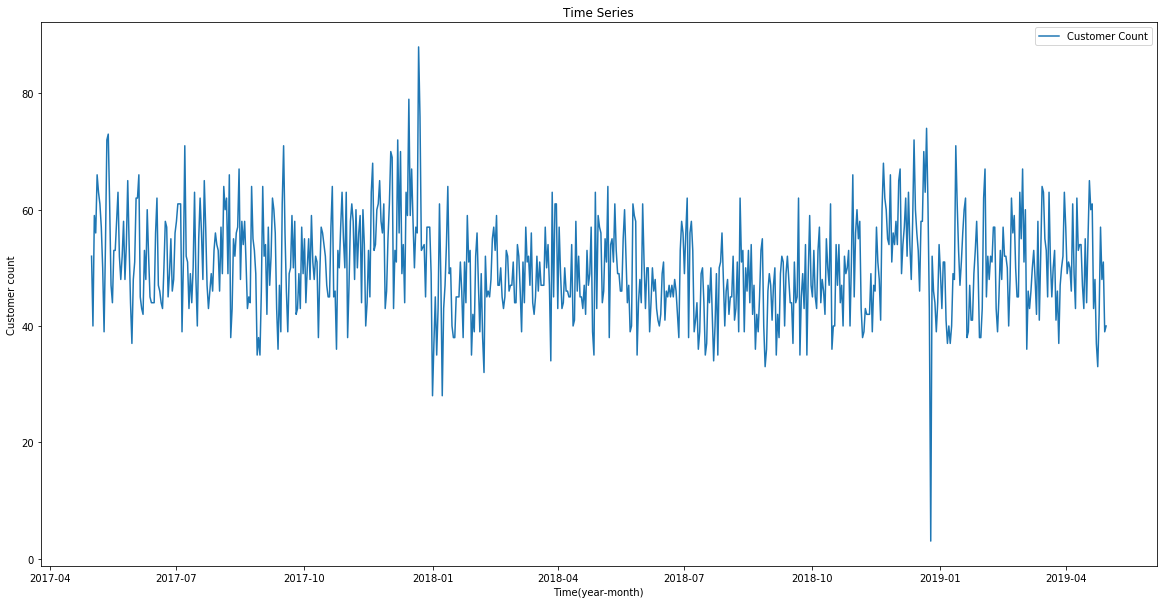

In [39]:
ts.index = ts['order_date'] # indexing the Datetime to get the time period on the x-axis.
ts = ts['count']
plt.figure(figsize=(20,10)) 
plt.plot(ts, label='Customer Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Customer count") 
plt.legend(loc='best')

Observations
- Here we can infer that there is no changing trend in the data, i.e., the number of counts remains same with respect to time. We can also see that at certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event thanksgiving / holiday the sales was high.
- There is one huge dip around the start of this year, which I am not sure of why.

### Q2 What is the replenishment behavior like in Dotcom and OG (or) what drives customers to shop with us again?

From the hypothesis and its validation I can see that, Holiday seasons, discount and offers, Salary dates, weekends primarly makes customer buy more.

### Uptill here I was including Store in my analysis. Now I will move on to just DOTCOM and OG mediums of shopping.

Going again on the steps covered in the previous section.

In [40]:
#read file
data1 = pd.read_excel('customer.csv')

In [41]:
data1 = data1[(data1['sales']>0)]

In [42]:
data1['order_date'] = pd.to_datetime(data1.order_date,format='%d-%m-%Y')

In [43]:
data1['year']=data1.order_date.dt.year 
data1['month']=data1.order_date.dt.month 
data1['day']=data1.order_date.dt.day

In [44]:
# I removed all the customer shopping on STORE and reset the index.
data1 = data1[(data1['shopping_medium'] != 'STORE')].reset_index(drop = True)

In [45]:
data1.apply(lambda x: len(x.unique()))

customer_id         481
order_date          675
shopping_medium       2
department           25
sales              2204
year                  3
month                12
day                  31
dtype: int64

In [46]:
data1.head()

,customer_id,order_date,shopping_medium,department,sales,year,month,day
0,407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1
1,971,2017-05-02,DOTCOM,APPAREL,48.44,2017,5,2
2,617,2017-05-02,DOTCOM,ELECTRONICS,29.99,2017,5,2
3,827,2017-05-03,DOTCOM,ELECTRONICS,39.99,2017,5,3
4,483,2017-05-04,DOTCOM,HOME IMPROVEMENT,115.17,2017,5,4


In [47]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3354 entries, 0 to 3353
Data columns (total 8 columns):
customer_id        3354 non-null int64
order_date         3354 non-null datetime64[ns]
shopping_medium    3354 non-null object
department         3252 non-null object
sales              3354 non-null float64
year               3354 non-null int64
month              3354 non-null int64
day                3354 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 209.7+ KB


In [48]:
data1.describe()

,customer_id,sales,year,month,day
count,3354.000000,3354.000000,3354.000000,3354.000000,3354.000000
mean,487.107633,117.416279,2017.953787,6.652355,16.071556
std,303.733318,1736.468709,0.673701,3.644616,8.801466
min,2.000000,0.090000,2017.000000,1.000000,1.000000
25%,192.250000,10.000000,2017.000000,3.000000,9.000000
50%,427.000000,24.640000,2018.000000,6.000000,16.000000
75%,810.000000,64.330000,2018.000000,10.000000,24.000000
max,1000.000000,71262.000000,2019.000000,12.000000,31.000000


In [49]:
data2 = data1.groupby('customer_id')
data2 = data2.size().reset_index(name='count')

In [50]:
data2.head()

,customer_id,count
0,2,1
1,4,1
2,6,1
3,7,2
4,9,1


In [51]:
#mergin the two data frame to include count against the customer.
df_merge = pd.merge(data1, data2, on='customer_id')

In [52]:
df_merge.head()

,customer_id,order_date,shopping_medium,department,sales,year,month,day,count
0,407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1,153
1,407,2017-05-09,DOTCOM,TOYS,8.82,2017,5,9,153
2,407,2017-05-11,DOTCOM,PHOTO,6.84,2017,5,11,153
3,407,2017-06-03,DOTCOM,ARTS AND CRAFTS,19.94,2017,6,3,153
4,407,2017-06-05,DOTCOM,HOME IMPROVEMENT,27.61,2017,6,5,153


In [53]:
#Filter categorical variables
categorical_columns = [x for x in df_merge.dtypes.index if df_merge.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['customer_id','Order_date','sales']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print(df_merge[col].value_counts())


Frequency of Categories for varible shopping_medium
DOTCOM    2230
OG        1124
Name: shopping_medium, dtype: int64

Frequency of Categories for varible department
GROCERY              476
HOUSEHOLD            405
ROOMS                371
HEALTH AND BEAUTY    302
ELECTRONICS          223
BABY                 179
APPAREL              169
TOYS                 165
PHOTO                147
BOOKS                137
HOME IMPROVEMENT      82
SPORTING GOODS        82
OFFICE SUPPLIES       80
AUTOMOTIVE PARTS      71
PETS                  71
HOME DECOR            54
ARTS AND CRAFTS       50
OUTDOOR               48
TOOLS EQUIPMENT       39
SERVICES              35
PERSONAL CARE         22
FOOTWEAR              18
ACCESSORIES           16
JEWELRY               10
Name: department, dtype: int64


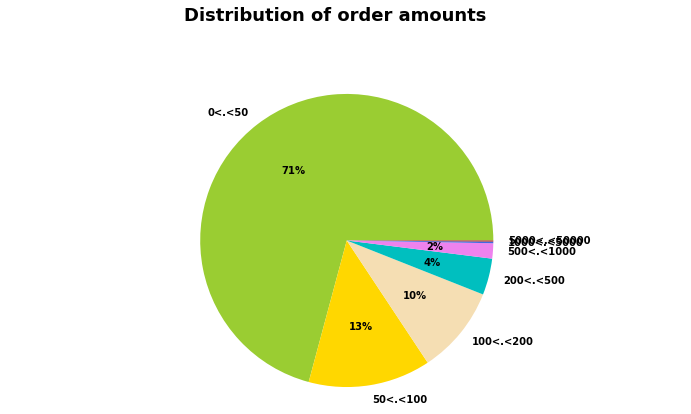

In [54]:
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = df_merge[(df_merge['sales'] < price) &
                       (df_merge['sales'] > price_range[i-1])]['sales'].count()
    count_price.append(val)

# Representation of the number of purchases / amount       
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(12, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

Observations
- More than 71% of buying of the product or products costing total between 0 to 50 dollars as hypotheised.
- Around 84% of customers buying order are under 100 dollars.

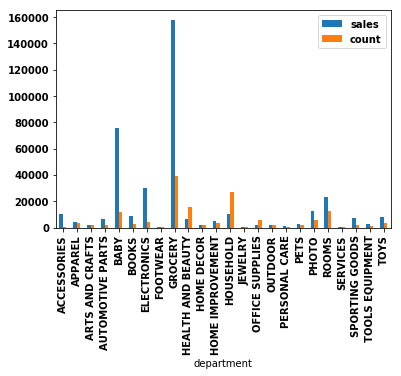

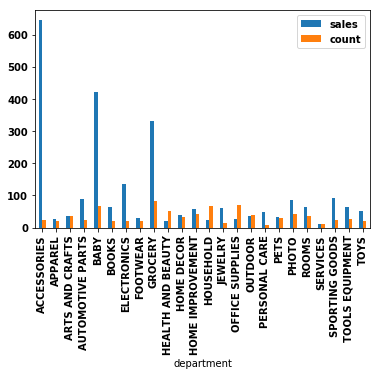

In [55]:
#Hypothesis test
df_merge.groupby('department')[['sales', 'count']].sum().plot.bar()
df_merge.groupby('department')[['sales', 'count']].mean().plot.bar()

Observations-
- First graph have total of sales and count and second graph has average of sales and count.
- We can see that though total income from the grocery is max but again we can also see that Accessories are very costly as having very high cost.
- Apart from this we can see people shop a lot for babies and both count as well as sales are decent and consistent enough.
- Household items seems to be cheaper as though the total count looks significant but its not generating much sales. Same goes for office supplies.

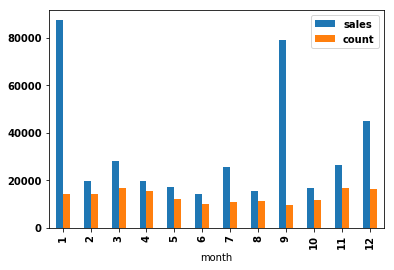

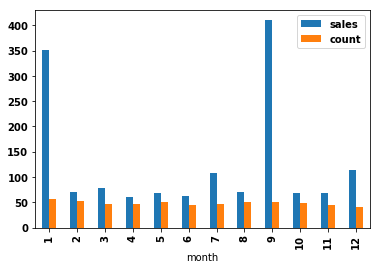

In [56]:
#Hypothesis test
df_merge.groupby('month')[['sales', 'count']].sum().plot.bar()
df_merge.groupby('month')[['sales', 'count']].mean().plot.bar()

Observations-
- Surprisingly and contrasting to the overall data, the data from OG and DOTCOM have maximum sales in month of Sep after Jan.
- The sale in Jan and Dec comes next after sep in terms of average sales.
- Seems like SEP, JAN and DEC are very good for business and should be focussed upon.

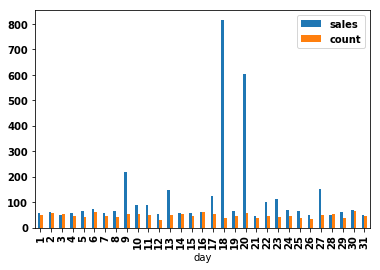

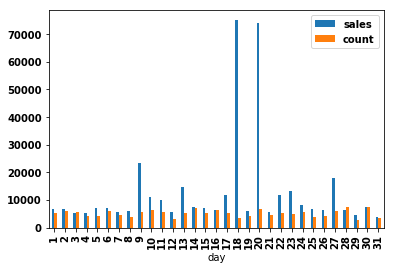

In [57]:
#Hypothesis test
df_merge.groupby('day')[['sales', 'count']].mean().plot.bar()
#Hypothesis test
df_merge.groupby('day')[['sales', 'count']].sum().plot.bar()

Observation
- It seems that my hypothesis about the average sales cornered around payment dates somehat stands true for DOTCOM and OG, but only for the 17-20.

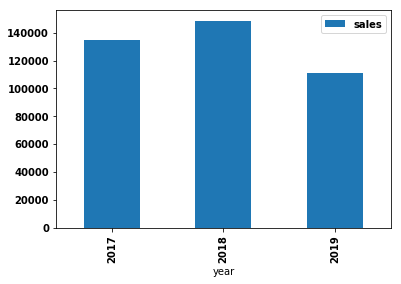

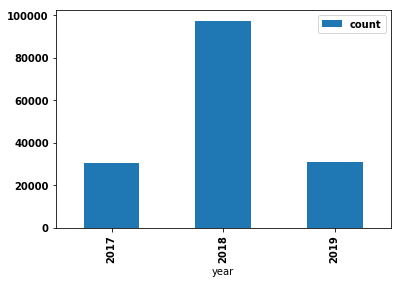

In [58]:
#Hypothesis test
df_merge.groupby('year')[['sales']].sum().plot.bar()
#Hypothesis test
df_merge.groupby('year')[['count']].sum().plot.bar()

Observations
- Sales has significantly increased over 2019 as just 4 months data have large sums of sales and counts.

In [59]:
# Lets create a new data frame to better analyse sales from these two shopping mediums according to different department. 
trial = pd.DataFrame()
for b in list(df_merge["department"].unique()):
    for v in list(df_merge["shopping_medium"].unique()):
        z = df_merge[(df_merge["department"] == b) & (df_merge["shopping_medium"] == v)]["sales"].mean()
        trial = trial.append(pd.DataFrame({'department':b , 'shopping_medium':v , 'avgSales':z}, index=[0]))
trial = trial.reset_index()
del trial["index"]
trial["avgSales"].fillna(0,inplace=True)
trial["avgSales"].isnull().value_counts()
trial["avgSales"] = trial["avgSales"].astype(float)
trial.head()

,department,shopping_medium,avgSales
0,PHOTO,DOTCOM,86.922857
1,PHOTO,OG,0.000000
2,TOYS,DOTCOM,52.535506
3,TOYS,OG,8.052857
4,ARTS AND CRAFTS,DOTCOM,40.772500


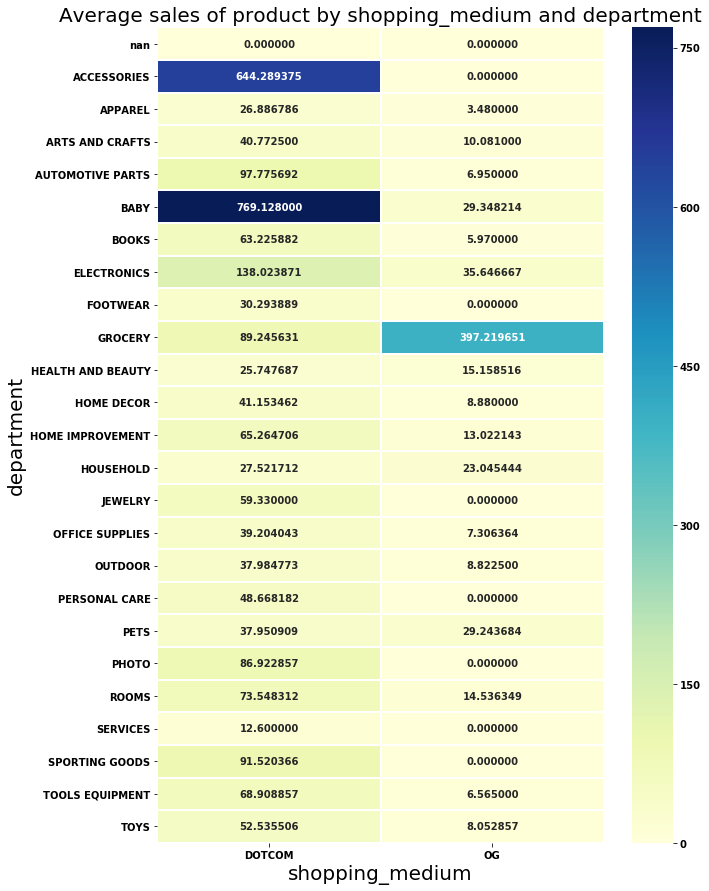

In [60]:
# HeatMap show average sales from different departments and shopping_medium together
tri = trial.pivot("department","shopping_medium", "avgSales")
fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(tri,linewidths=1,cmap="YlGnBu",annot=True, ax=ax, fmt="f")
ax.set_title("Average sales of product by shopping_medium and department",fontdict={'size':20})
ax.xaxis.set_label_text("shopping_medium",fontdict= {'size':20})
ax.yaxis.set_label_text("department",fontdict= {'size':20})
plt.show()

Observation
- OG stands for its name and maximum from groceries.
- DOTCOM earns maximum from ACCESSORIES AND BABY products though they have there rest of sales distributed almost uniformly over other products.

In [61]:
# Lets create a new data frame to better analyse traffic on these two shopping mediums according to different department.
trial = pd.DataFrame()
for b in list(df_merge["department"].unique()):
    for v in list(df_merge["shopping_medium"].unique()):
        z = df_merge[(df_merge["department"] == b) & (df_merge["shopping_medium"] == v)]["count"].count()
        trial = trial.append(pd.DataFrame({'department':b , 'shopping_medium':v , 'count':z}, index=[0]))
trial = trial.reset_index()
del trial["index"]
trial["count"].fillna(0,inplace=True)
trial["count"].isnull().value_counts()
trial["count"] = trial["count"].astype(int)
trial.head()

,department,shopping_medium,count
0,PHOTO,DOTCOM,147
1,PHOTO,OG,0
2,TOYS,DOTCOM,158
3,TOYS,OG,7
4,ARTS AND CRAFTS,DOTCOM,40


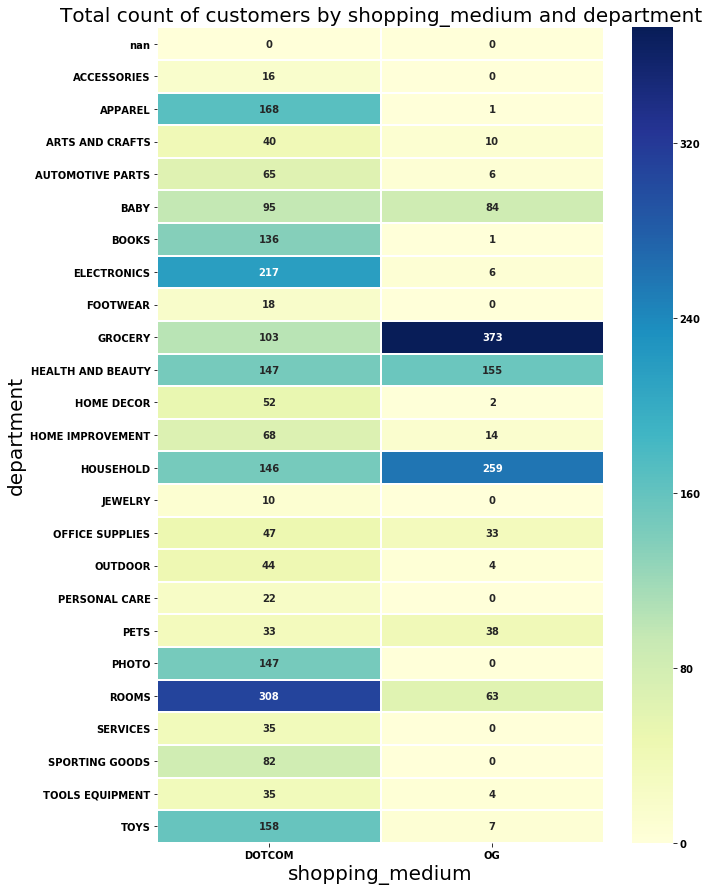

In [62]:
# HeatMap show total count of customers by department and shopping_medium.
tri = trial.pivot("department","shopping_medium", "count")
fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(tri,linewidths=1,cmap="YlGnBu",annot=True, ax=ax, fmt="d")
ax.set_title("Total count of customers by shopping_medium and department",fontdict={'size':20})
ax.xaxis.set_label_text("shopping_medium",fontdict= {'size':20})
ax.yaxis.set_label_text("department",fontdict= {'size':20})
plt.show()

observations-
- OG has maximum customer count in Grocery as obvious but significant count in health & beauty and household.
- Though the count is significant but not the sales, as seen in previous graph. Hence, either they are cheap or customer are less interested in premium products in these department. Same behavior goes for Apparel and ROOMS in DOTCOM.
- DOTCOM is selling maximum and premium products in Baby department as expected from previous conclusions.

In [63]:
#Lets create a new data frame to better analyse visitor count from different department according to month. 
trial = pd.DataFrame()
for b in list(df_merge["department"].unique()):
    for v in list(df_merge["month"].unique()):
        z = df_merge[(df_merge["department"] == b) & (df_merge["month"] == v)]["count"].count()
        trial = trial.append(pd.DataFrame({'department':b , 'month':v , 'count':z}, index=[0]))
trial = trial.reset_index()
del trial["index"]
trial["count"].fillna(0,inplace=True)
trial["count"].isnull().value_counts()
trial["count"] = trial["count"].astype(int)
trial.head()

,department,month,count
0,PHOTO,5,18
1,PHOTO,6,12
2,PHOTO,7,2
3,PHOTO,8,10
4,PHOTO,9,14


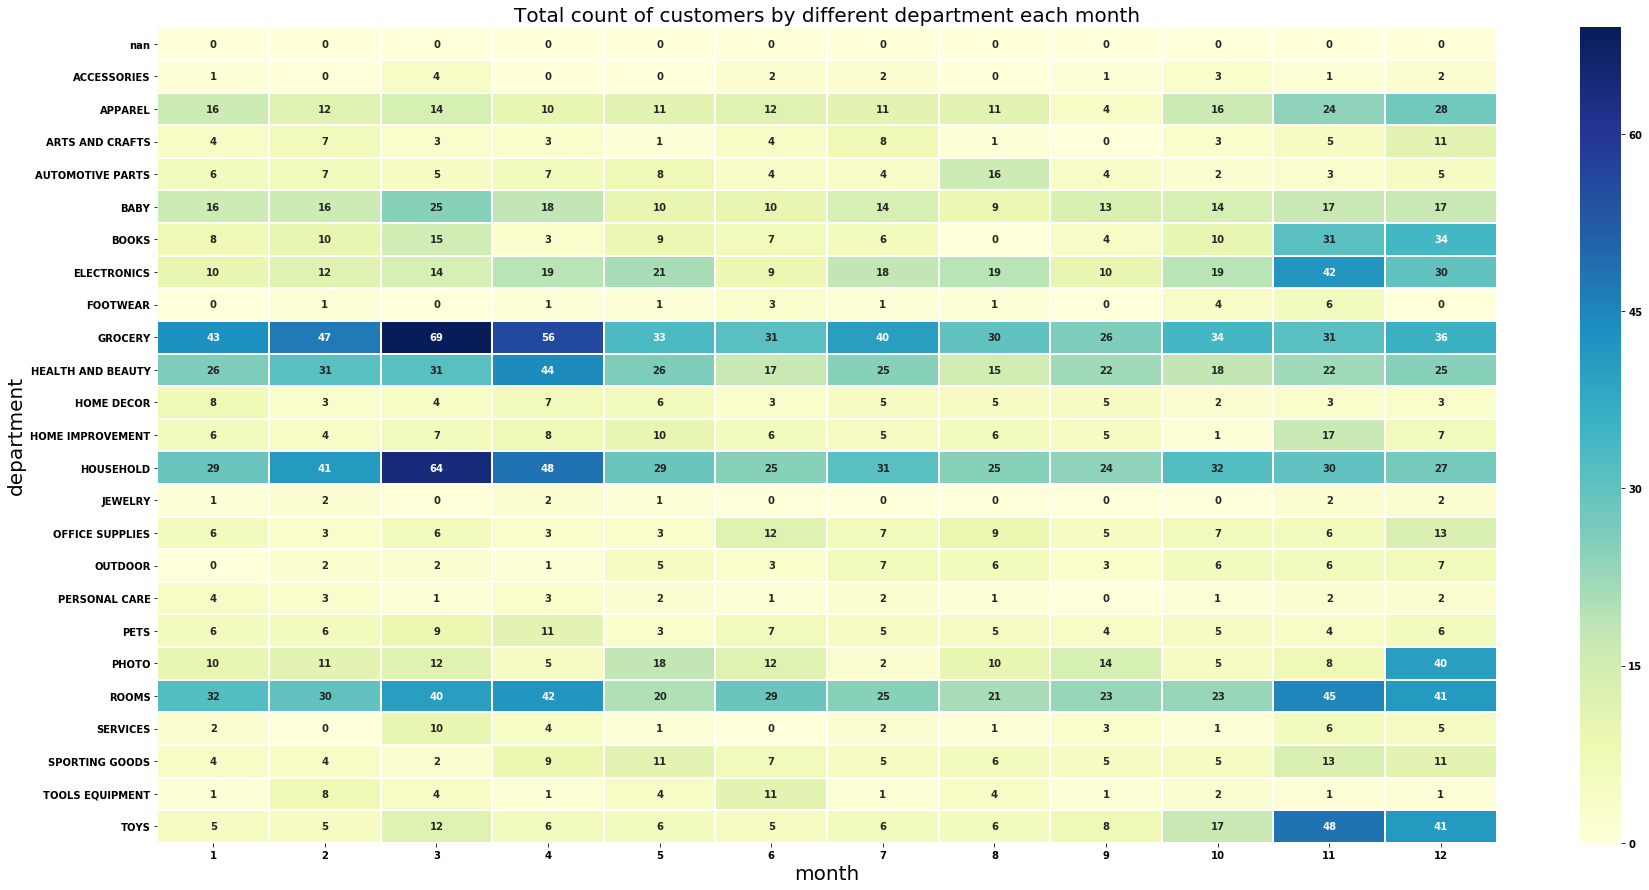

In [64]:
# HeatMap show total count of customers according to different months in different departments.
tri = trial.pivot("department","month", "count")
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(tri,linewidths=1,cmap="YlGnBu",annot=True, ax=ax, fmt="d")
ax.set_title("Total count of customers by different department each month",fontdict={'size':20})
ax.xaxis.set_label_text("month",fontdict= {'size':20})
ax.yaxis.set_label_text("department",fontdict= {'size':20})
plt.show()

observations-
- My hypothesis again stands here, customers looking for grocery is through out consistent.
- Toys have a decent customers in case of Nov and DEC, this could might be from festive season and offers such as Thanksgiving etc. Also for last 2 months we can see spikes in Electronics and other departments as compared to rest of months for the same stated reasons.

In [65]:
#Lets create a new data frame to better analyse again total sales from different department according to month. 
trial = pd.DataFrame()
for b in list(df_merge["department"].unique()):
    for v in list(df_merge["month"].unique()):
        z = df_merge[(df_merge["department"] == b) & (df_merge["month"] == v)]["sales"].sum()
        trial = trial.append(pd.DataFrame({'department':b , 'month':v , 'totSale':z}, index=[0]))
trial = trial.reset_index()
del trial["index"]
trial["totSale"].fillna(0,inplace=True)
trial["totSale"].isnull().value_counts()
trial["totSale"] = trial["totSale"].astype(float)
trial.head()

,department,month,totSale
0,PHOTO,5,202.94
1,PHOTO,6,155.02
2,PHOTO,7,36.10
3,PHOTO,8,132.85
4,PHOTO,9,151.94


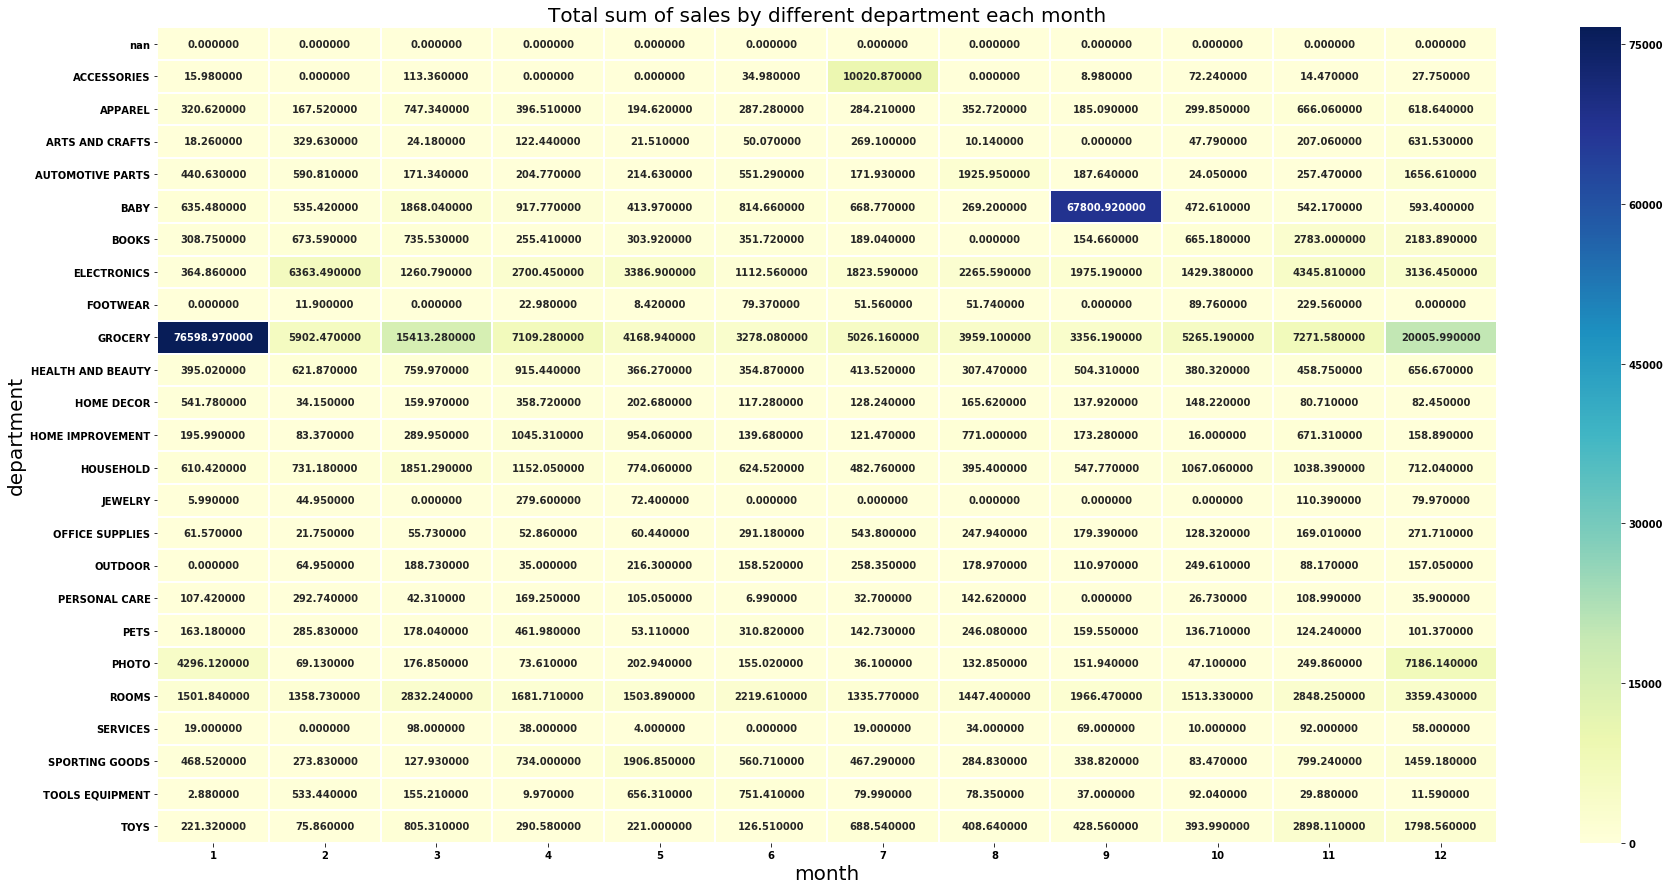

In [66]:
# HeatMap show total sales according to different months in different departments.
tri = trial.pivot("department","month", "totSale")
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(tri,linewidths=1,cmap="YlGnBu",annot=True, ax=ax, fmt="f")
ax.set_title("Total sum of sales by different department each month",fontdict={'size':20})
ax.xaxis.set_label_text("month",fontdict= {'size':20})
ax.yaxis.set_label_text("department",fontdict= {'size':20})
plt.show()

Observations-
- Baby has an exceptional sales in month of September and its mysterious to me. Though I didn't dig deeper but the obvious reasons could be 1.) There could be some outlier such as few families who bought a lot of baby products in hat month. 2.) People expect a lot of babies in month of Sep but that seem unlikely to me.

In [67]:
#Lets create a new data frame to better analyse again total customer count from different department each day.
trial = pd.DataFrame()
for b in list(df_merge["department"].unique()):
    for v in list(df_merge["day"].unique()):
        z = df_merge[(df_merge["department"] == b) & (df_merge["day"] == v)]["count"].count()
        trial = trial.append(pd.DataFrame({'department':b , 'day':v , 'count':z}, index=[0]))
trial = trial.reset_index()
del trial["index"]
trial["count"].fillna(0,inplace=True)
trial["count"].isnull().value_counts()
trial["count"] = trial["count"].astype(int)
trial.head()

,department,day,count
0,PHOTO,1,2
1,PHOTO,9,3
2,PHOTO,11,8
3,PHOTO,3,4
4,PHOTO,5,2


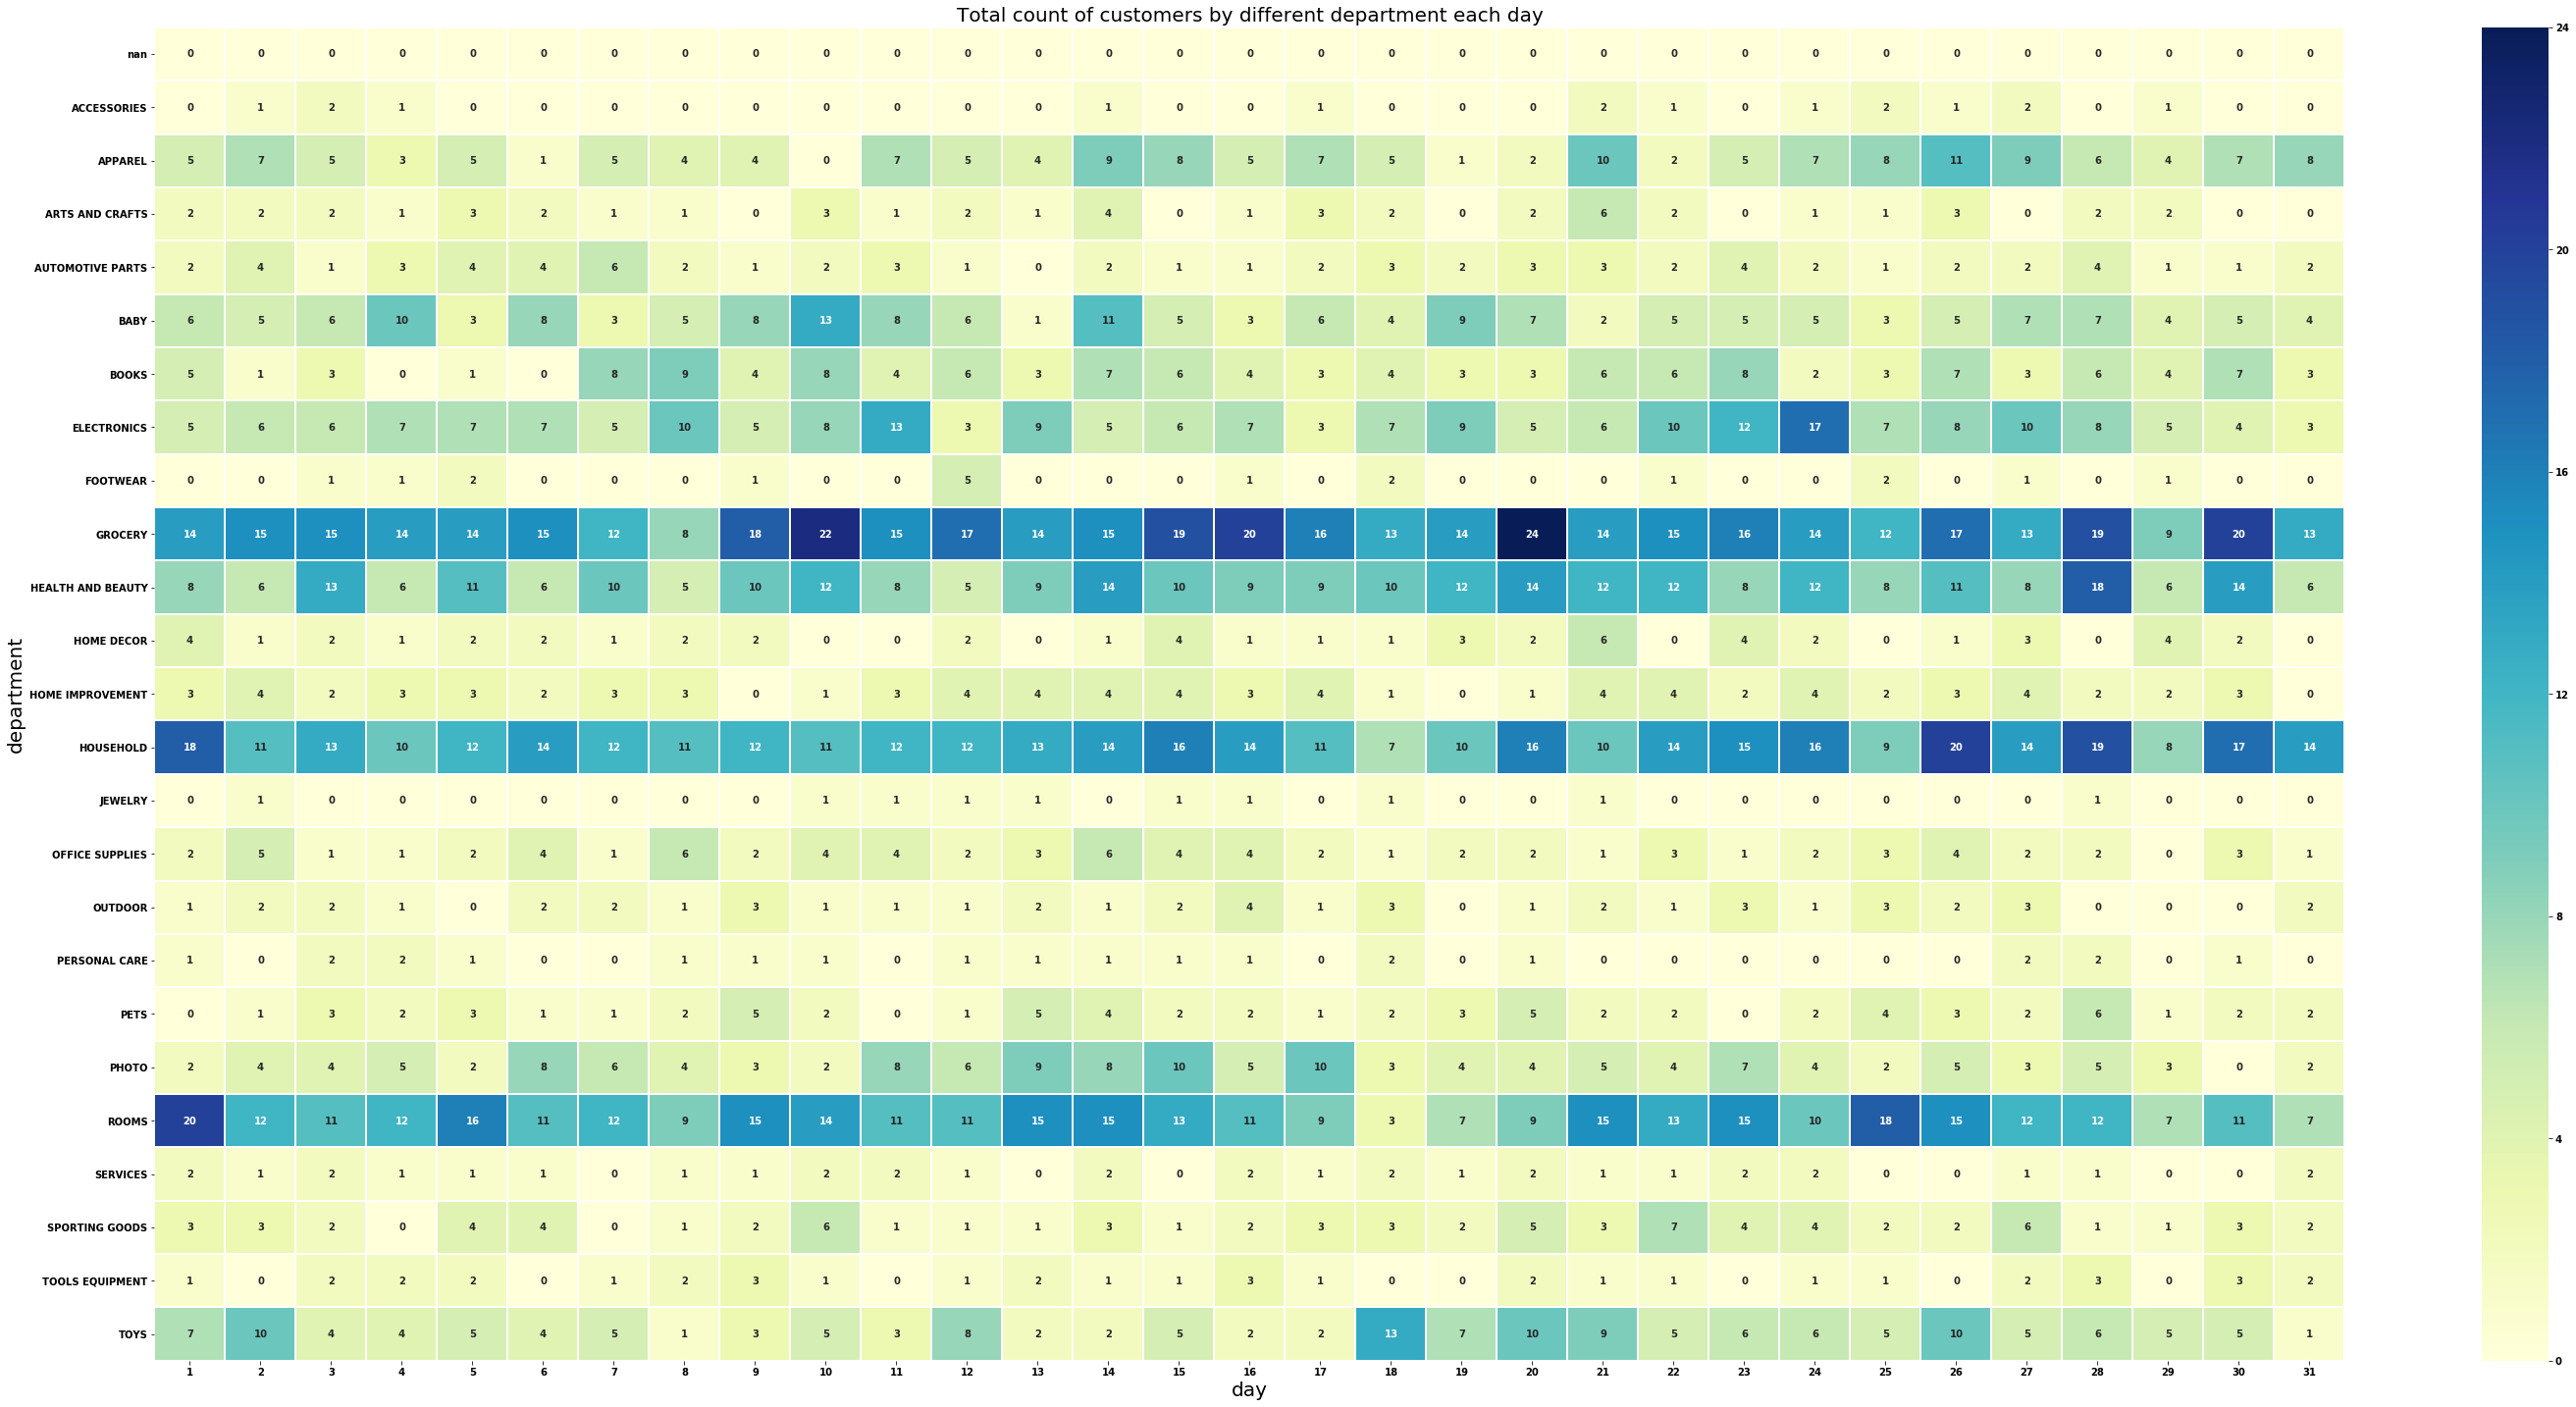

In [68]:
# HeatMap shows total count of customer by department each day.
tri = trial.pivot("department","day", "count")
fig, ax = plt.subplots(figsize=(50,25))
sns.heatmap(tri,linewidths=1,cmap="YlGnBu",annot=True, ax=ax, fmt="d")
ax.set_title("Total count of customers by different department each day",fontdict={'size':20})
ax.xaxis.set_label_text("day",fontdict= {'size':20})
ax.yaxis.set_label_text("department",fontdict= {'size':20})
plt.show()

Observations:
- Grocery stands out consistent here again confirming the hypothesis.

### Cohort Analysis

In [69]:
#creating a period based column on order_date
df_merge['order_period'] = df_merge.order_date.apply(lambda x: x.strftime('%Y-%m'))
df_merge.head()

,customer_id,order_date,shopping_medium,department,sales,year,month,day,count,order_period
0,407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1,153,2017-05
1,407,2017-05-09,DOTCOM,TOYS,8.82,2017,5,9,153,2017-05
2,407,2017-05-11,DOTCOM,PHOTO,6.84,2017,5,11,153,2017-05
3,407,2017-06-03,DOTCOM,ARTS AND CRAFTS,19.94,2017,6,3,153,2017-06
4,407,2017-06-05,DOTCOM,HOME IMPROVEMENT,27.61,2017,6,5,153,2017-06


In [70]:
#creating a columns callled CohortGroup having year and month in which a customer buys for the first time.
order_period_grouped = df_merge.groupby('order_period')
order_period_agg = order_period_grouped.agg({'customer_id': pd.Series.nunique,
                                             'department': pd.Series.nunique,
                                             'sales': np.sum})
order_period_agg.rename(columns ={'cust_id':'total_customers',
                                  'department':'total_department_types',
                                  'sales':'total_sales'}, inplace = True)
order_period_agg.head()

,customer_id,total_department_types,total_sales
order_period,,,
2017-05,46,19,4846.19
2017-06,43,21,4039.15
2017-07,41,18,13392.82
2017-08,37,18,4641.39
2017-09,42,18,70791.81


In [71]:
df_merge.set_index('customer_id', inplace = True)
df_merge.head()

,order_date,shopping_medium,department,sales,year,month,day,count,order_period
customer_id,,,,,,,,,
407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1,153,2017-05
407,2017-05-09,DOTCOM,TOYS,8.82,2017,5,9,153,2017-05
407,2017-05-11,DOTCOM,PHOTO,6.84,2017,5,11,153,2017-05
407,2017-06-03,DOTCOM,ARTS AND CRAFTS,19.94,2017,6,3,153,2017-06
407,2017-06-05,DOTCOM,HOME IMPROVEMENT,27.61,2017,6,5,153,2017-06


In [72]:
#Group the transactions by customers order date. strftime function is applied to create the new label for cohort group.
df_merge['cohort_group'] = df_merge.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df_merge.head()

,order_date,shopping_medium,department,sales,year,month,day,count,order_period,cohort_group
customer_id,,,,,,,,,,
407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1,153,2017-05,2017-05
407,2017-05-09,DOTCOM,TOYS,8.82,2017,5,9,153,2017-05,2017-05
407,2017-05-11,DOTCOM,PHOTO,6.84,2017,5,11,153,2017-05,2017-05
407,2017-06-03,DOTCOM,ARTS AND CRAFTS,19.94,2017,6,3,153,2017-06,2017-05
407,2017-06-05,DOTCOM,HOME IMPROVEMENT,27.61,2017,6,5,153,2017-06,2017-05


In [73]:
df_merge.reset_index(inplace = True)
df_merge.head()

,customer_id,order_date,shopping_medium,department,sales,year,month,day,count,order_period,cohort_group
0,407,2017-05-01,DOTCOM,PHOTO,3.80,2017,5,1,153,2017-05,2017-05
1,407,2017-05-09,DOTCOM,TOYS,8.82,2017,5,9,153,2017-05,2017-05
2,407,2017-05-11,DOTCOM,PHOTO,6.84,2017,5,11,153,2017-05,2017-05
3,407,2017-06-03,DOTCOM,ARTS AND CRAFTS,19.94,2017,6,3,153,2017-06,2017-05
4,407,2017-06-05,DOTCOM,HOME IMPROVEMENT,27.61,2017,6,5,153,2017-06,2017-05


In [74]:
#creating aggregate metrics for different cohort_group
#count the total number of customers and sales in a period by customer_id and department. 
#sum the sales amount to get the aggregate sales for the periods.
grouped = df_merge.groupby(['cohort_group','order_period'])
cohorts = grouped.agg({'customer_id': pd.Series.nunique,
                       'department': pd.Series.nunique,
                       'sales': np.sum})
cohorts.rename(columns ={'customer_id':'total_customers',
                         'department':'total_department_types',
                         'sales':'total_sales'}, inplace = True)
cohorts.head()

total_customers  total_department_types  \
cohort_group order_period                                            
2017-05      2017-05                    46                      19   
             2017-06                    12                      16   
             2017-07                    11                      11   
             2017-08                    12                      12   
             2017-09                    11                      16   

                           total_sales  
cohort_group order_period               
2017-05      2017-05           4846.19  
             2017-06           2460.15  
             2017-07           1633.85  
             2017-08           2113.01  
             2017-09           1216.50

In [75]:
#creating labels for order_period within cohort_groups
def cohort_period(df_merge):
    df_merge['cohort_period'] = np.arange(len(df_merge)) + 1
    return df_merge

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_customers  total_department_types  \
cohort_group order_period                                            
2017-05      2017-05                    46                      19   
             2017-06                    12                      16   
             2017-07                    11                      11   
             2017-08                    12                      12   
             2017-09                    11                      16   

                           total_sales  cohort_period  
cohort_group order_period                              
2017-05      2017-05           4846.19              1  
             2017-06           2460.15              2  
             2017-07           1633.85              3  
             2017-08           2113.01              4  
             2017-09           1216.50              5

Text(0.5,1,'Retention Rates Across Customers')

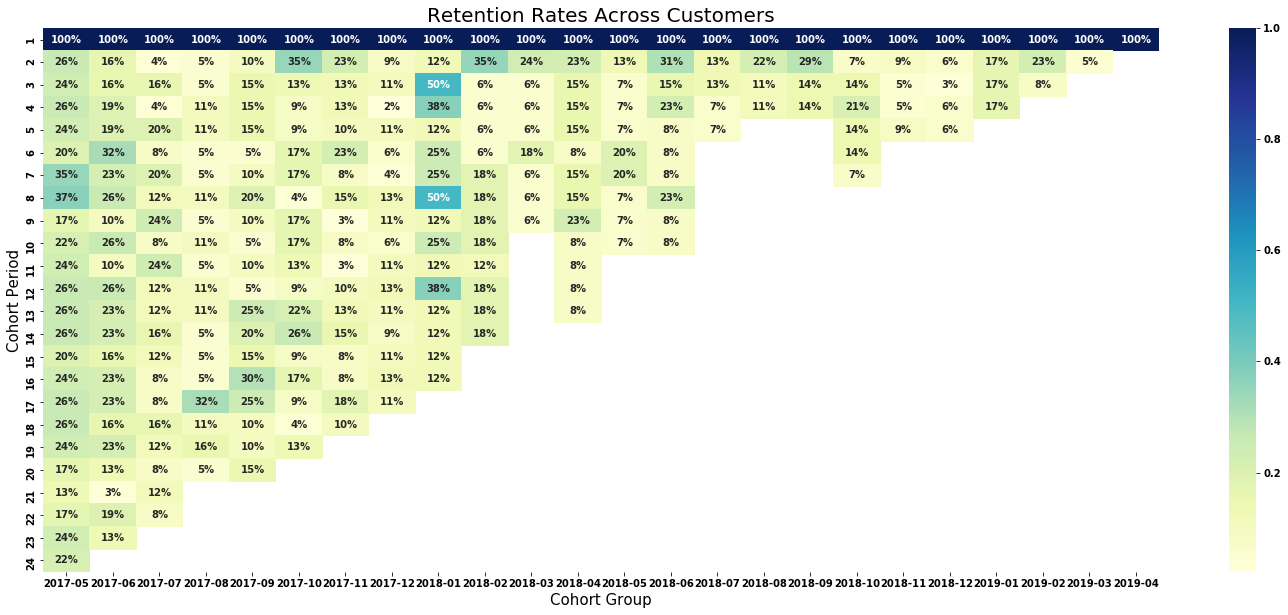

In [76]:
#heatmap for percentage of customer retention.
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

cohort_sizes = cohorts.groupby(level=0)['total_customers'].first()
customer_retention = cohorts['total_customers'].unstack(0).divide(cohort_sizes, axis = 1)
plt.figure(figsize=(25,10))
ax = sns.heatmap(customer_retention, annot=True,cmap='YlGnBu', fmt='.0%')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Retention Rates Across Customers', fontsize = 20)

observations-
- 35% of customers from 2017-05 cohort_group still buying again in 2017-11.
- Non-uniform distribution of retention rate

Text(0.5,1,'Monthly Total Sales Across Cohorts')

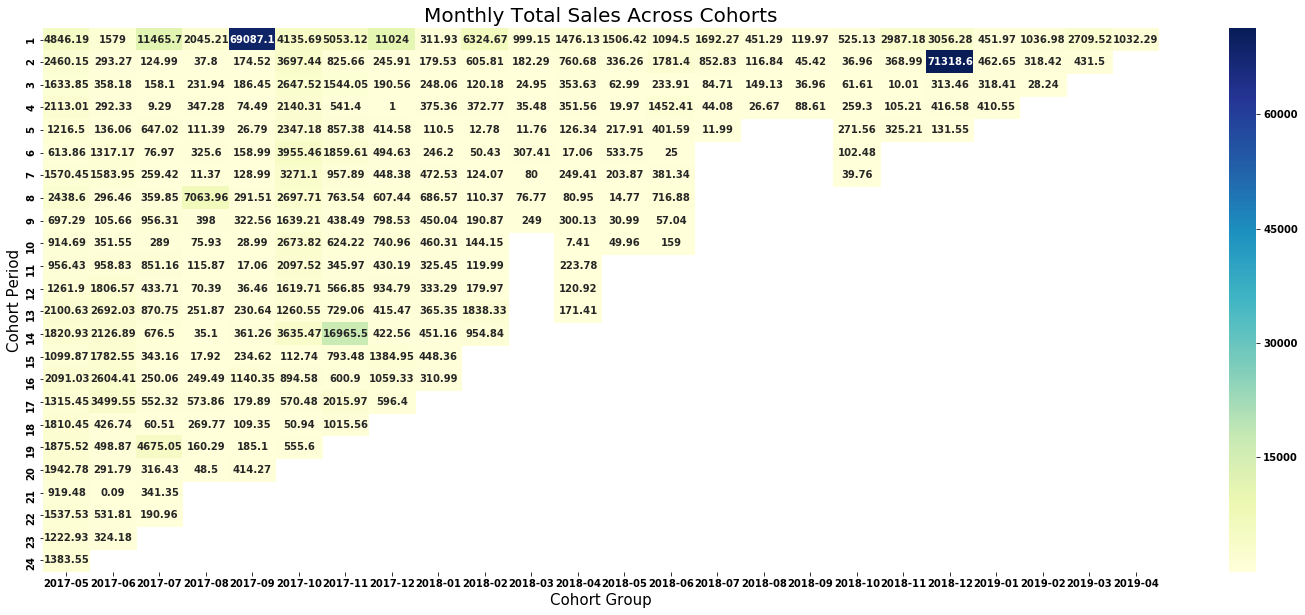

In [77]:
#heatmap for Monthly total sales
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_group', 'cohort_period'], inplace=True)

unstacked_order = cohorts['total_sales'].unstack(0)
plt.figure(figsize=(25,10))
ax = sns.heatmap(unstacked_order, annot=True,cmap='YlGnBu', fmt='g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Total Sales Across Cohorts', fontsize = 20)

observation-
- overall decreasing trend across cohorts

Text(0.5,1,'Monthly Active Customers Across Cohorts')

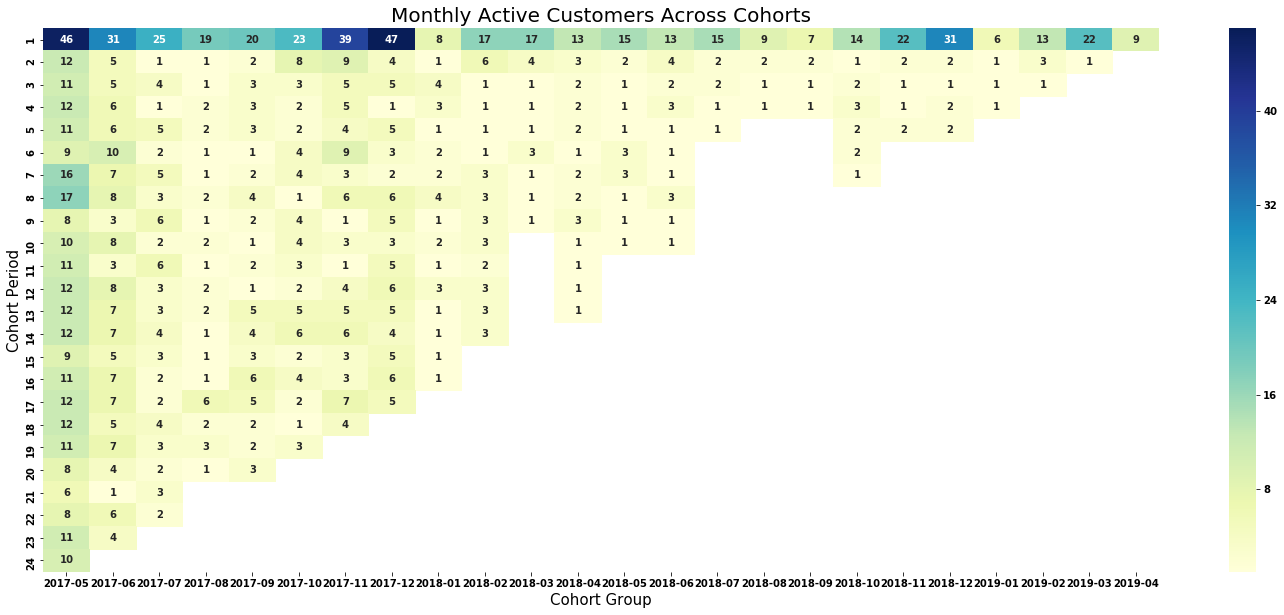

In [78]:
#heatmap for total no of customer retention
unstacked_cust = cohorts['total_customers'].unstack(0)
plt.figure(figsize=(25,10))
ax = sns.heatmap(unstacked_cust, annot = True, cmap='YlGnBu', fmt = 'g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Active Customers Across Cohorts', fontsize = 20)

observation-
- Again overall decrease in no of customers

Text(0.5,1,'Monthly Department Retention Across Cohorts')

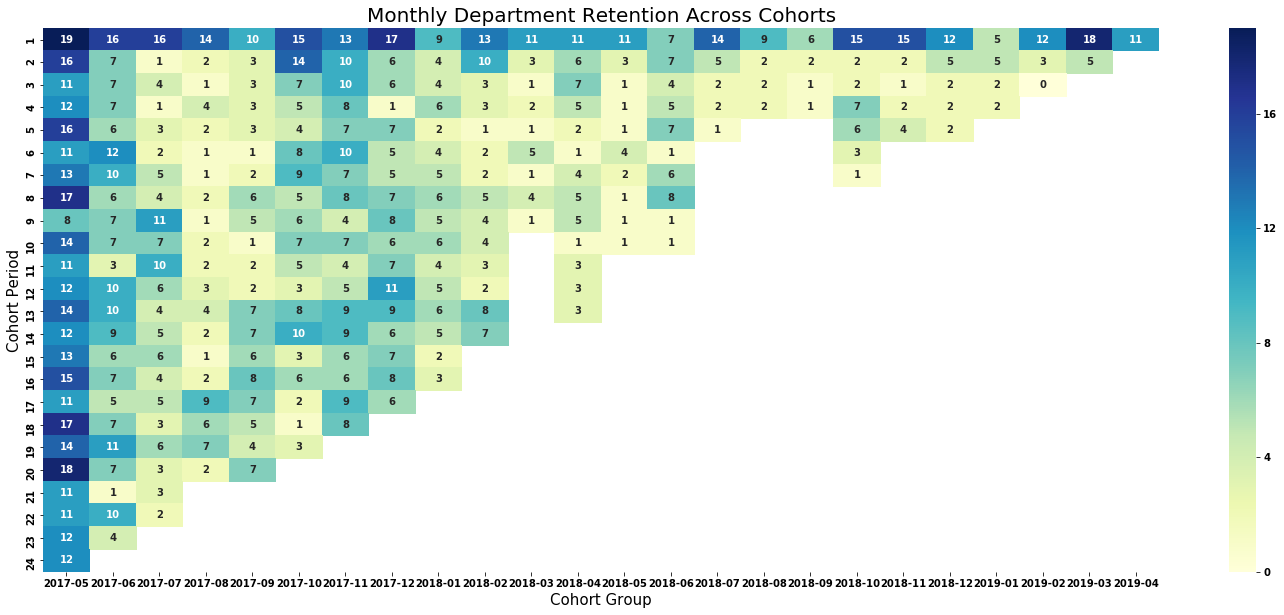

In [79]:
#heatmap for department retention across cohorts
unstacked_cust = cohorts['total_department_types'].unstack(0)
plt.figure(figsize=(25,10))
ax = sns.heatmap(unstacked_cust, annot = True, cmap='YlGnBu', fmt = 'g')
ax.set_ylabel('Cohort Period', fontsize = 15)
ax.set_xlabel('Cohort Group', fontsize = 15)
ax.set_title('Monthly Department Retention Across Cohorts', fontsize = 20)

### Above are the customer behavior across the OG and DOTCOM shopping_medium.